### Project: Amazon pet supplies product reviews sentiment analysis using different models 
### Python version: 3.10.12



# Part1: 

In [6]:
import pandas as pd  
import numpy as np
import re
import matplotlib as plt
import seaborn as sns
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer


In [5]:
df_raw = pd.read_csv("data.csv")
df = df_raw.copy()

NameError: name 'pd' is not defined

In [5]:
df.head(3)

,overall,reviewText,year_month
0,1.0,I was not happy with product would like to ret...,2016-12
1,1.0,This cd is scratched and it constantly skips. ...,2016-12
2,4.0,It works just fine and repeats when I'm not he...,2016-12


In [6]:
df.shape

(5820802, 3)

In [7]:
df.isnull().sum()

overall          0
reviewText    3928
year_month       0
dtype: int64

In [8]:
df = df.dropna()
print(df.shape)

(5816874, 3)


In [9]:
df.dtypes

overall       float64
reviewText     object
year_month     object
dtype: object

<Axes: xlabel='overall', ylabel='count'>

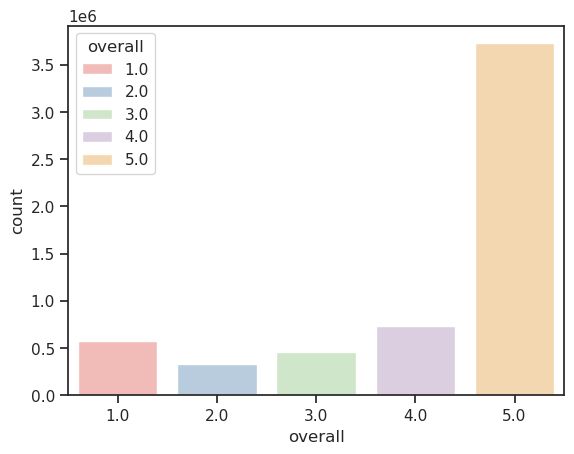

In [152]:
sns.countplot(data=df, x='overall',hue="overall", palette="Pastel1")

###  classify rating stars < 3 as negative review ("-1")

In [10]:
df.loc[df["overall"] < 3.0, 'overall'] = -1

###  classify rating score > 3 as posotive review ("1")

In [11]:
df.loc[df["overall"] > 3.0, 'overall'] = 1

###  classify rating score = 3 as neutral review ("0")

In [13]:
df.loc[df["overall"] == 3.0, 'overall'] = 0

### Visualizing the distribution of the three classes

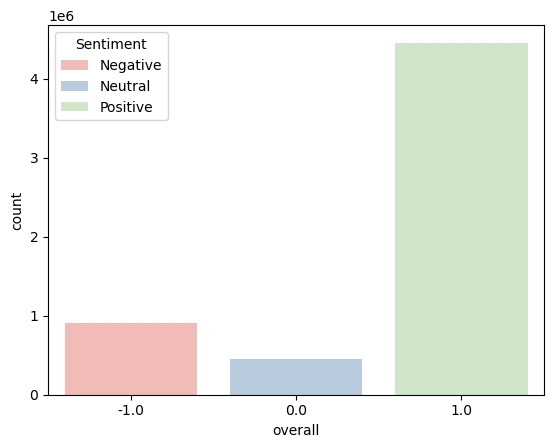

In [14]:
ax = sns.countplot(data=df, x='overall',hue="overall", palette="Pastel1")
handles, labels = ax.get_legend_handles_labels()
new_labels = ['Negative', 'Neutral', 'Positive'] 
ax.legend(handles, new_labels, title='Sentiment')

In [41]:
df[["reviewText"]].head(1)

,reviewText
0,I was not happy with product would like to ret...


In [15]:
def data_preprocess(text):
    text =  RegexpTokenizer(r'\w+|\$[0-9.]+|\d+').tokenize(text.lower())
    text = ' '.join(text)
    return text

In [16]:
df_copy = df.copy()
df_copy['Text'] = df_copy['reviewText'].apply(data_preprocess)
df_copy.head(10)

,overall,reviewText,year_month,Text
0,-1.0,I was not happy with product would like to ret...,2016-12,i was not happy with product would like to ret...
1,-1.0,This cd is scratched and it constantly skips. ...,2016-12,this cd is scratched and it constantly skips d...
2,1.0,It works just fine and repeats when I'm not he...,2016-12,it works just fine and repeats when i m not he...
3,0.0,I purchased this cd for my Pocket Parrot. It h...,2016-12,i purchased this cd for my pocket parrot it ha...
4,0.0,"Maybe it's just my Amazon parrot, but she's no...",2016-10,maybe it s just my amazon parrot but she s not...
5,1.0,I bought this to help me teach my blue quaker ...,2016-09,i bought this to help me teach my blue quaker ...
6,0.0,Bird showed no interest in it....,2016-08,bird showed no interest in it
7,-1.0,did not like at all,2016-08,did not like at all
8,-1.0,Didn't do a thing for my African Grey! He hate...,2016-08,didn t do a thing for my african grey he hated...
9,1.0,I like it - but the Cockatiel I am not so sure...,2016-07,i like it but the cockatiel i am not so sure h...


#### customize a stopwords list by removing negative words from nltk.corpus, but realized not much helpful for feature extraction and I will use raw text to train my model. 

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(words):
    words = words.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = ' '.join(words)
    return words

In [18]:
review = df_copy.copy()
review['Text1'] = review['Text'].apply(preprocess)
review.head(10)

,overall,reviewText,year_month,Text,Text1
0,-1.0,I was not happy with product would like to ret...,2016-12,i was not happy with product would like to ret...,happy product would like return work
1,-1.0,This cd is scratched and it constantly skips. ...,2016-12,this cd is scratched and it constantly skips d...,cd scratched constantly skip disappointed
2,1.0,It works just fine and repeats when I'm not he...,2016-12,it works just fine and repeats when i m not he...,work fine repeat bird still talking stay quiet...
3,0.0,I purchased this cd for my Pocket Parrot. It h...,2016-12,i purchased this cd for my pocket parrot it ha...,purchased cd pocket parrot woman man speaking ...
4,0.0,"Maybe it's just my Amazon parrot, but she's no...",2016-10,maybe it s just my amazon parrot but she s not...,maybe amazon parrot picking quickly well
5,1.0,I bought this to help me teach my blue quaker ...,2016-09,i bought this to help me teach my blue quaker ...,bought help teach blue quaker named booger tal...
6,0.0,Bird showed no interest in it....,2016-08,bird showed no interest in it,bird showed interest
7,-1.0,did not like at all,2016-08,did not like at all,like
8,-1.0,Didn't do a thing for my African Grey! He hate...,2016-08,didn t do a thing for my african grey he hated...,thing african grey hated obnoxious
9,1.0,I like it - but the Cockatiel I am not so sure...,2016-07,i like it but the cockatiel i am not so sure h...,like cockatiel sure listens far speak


#### take 10% of sample data to perform Exploratory Data Analysis

In [23]:
perc = 0.001  # 10% (change this value as needed)
sampled = review.sample(frac=perc, random_state=42)  # Randomly sample 10% of the data

from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your Pandas DataFrame with a column 'reviewText'
# Replace 'df' with your actual DataFrame name

# Concatenate all reviews into a single string
reviews_combined = ' '.join(df['reviewText'].astype(str))

# Perform part-of-speech tagging using TextBlob
blob = TextBlob(reviews_combined)
pos_tags = blob.tags

# Create a DataFrame with columns 'word' and 'pos'
pos_df = pd.DataFrame(pos_tags, columns=['word', 'pos'])

# Get the count of each part-of-speech tag and select the top 20
top_pos_tags = pos_df['pos'].value_counts().nlargest(20)

# Plotting the top 20 part-of-speech tags using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

sns.barplot(x=top_pos_tags.index, y=top_pos_tags.values, palette='viridis')
plt.title('Top 20 Part-of-Speech Tagging for Review Corpus')  # Set the title of the plot
plt.xlabel('POS')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Ensure all elements are properly placed

plt.show()  # Display the plot





KeyboardInterrupt: 

In [46]:
percentage = 0.1  # 10% (change this value as needed)
sampled_data = review.sample(frac=percentage, random_state=42)  # Randomly sample 10% of the data

#### Top 10 most common words in Positive reviews 

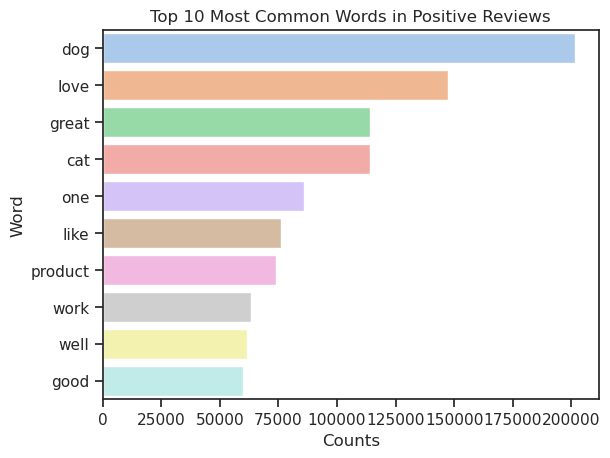

In [53]:
text = ' '.join(sampled_data[sampled_data['overall'] == 1]['Text1'])
words = text.split()  # Tokenizing the text into words
fd = FreqDist(words)  # Calculating the frequency distribution of words

top_10 = fd.most_common(10)
# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))
                  
sns.set_theme(style="ticks")
sns.barplot(y=fdist.index, x=fdist.values, palette='pastel',hue=fdist.index, legend=False).set( title="Top 10 Most Common Words in Positive Reviews") 
plt.xlabel('Counts')
plt.ylabel('Word')
plt.show()

#### Top 10 most common words in Negative reviews 

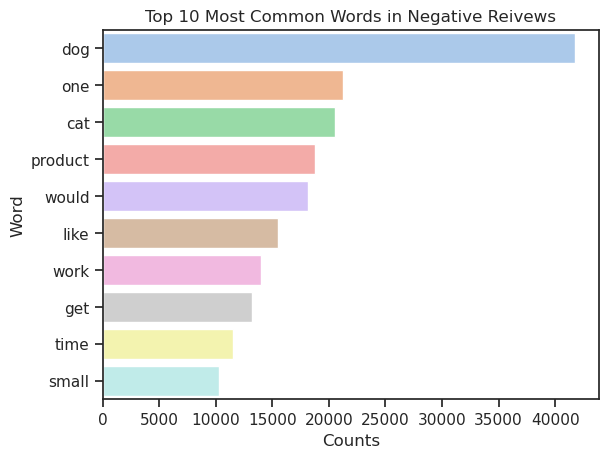

In [55]:
text = ' '.join(sampled_data[sampled_data['overall'] == -1]['Text1'])
words = text.split()  # Tokenizing the text into words
fd = FreqDist(words)  # Calculating the frequency distribution of words

top_10 = fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

sns.set_theme(style="ticks")
sns.barplot(y=fdist.index, x=fdist.values, palette='pastel',hue=fdist.index, legend=False).set( title="Top 10 Most Common Words in Negative Reivews") 
plt.xlabel('Counts')
plt.ylabel('Word')
plt.show()

#### Top 10 most common 2-words in Positive reviews 

[Text(0.5, 1.0, 'Top 10 Most Common Bigrams in Positive Reviews')]

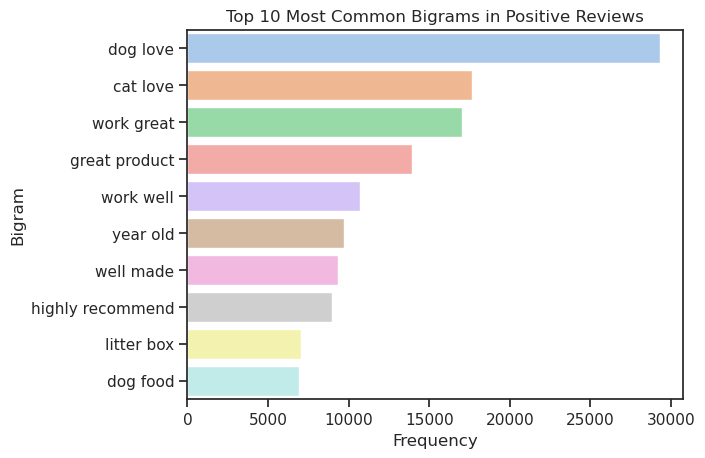

In [58]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(sampled_data[sampled_data['overall'] == 1]['Text1'])

count_values = np.array(bigrams.sum(axis=0)).flatten()
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["Frequency", "Bigram"]

sns.barplot(x=ngram_freq['Frequency'][:10], y=ngram_freq['Bigram'][:10],palette='pastel',hue=ngram_freq['Bigram'][:10], legend=False).set( title='Top 10 Most Common Bigrams in Positive Reviews')

#### Top 10 most common 2-words in Negative reviews 

[Text(0.5, 1.0, 'Top 10 Most Common Bigrams in Negative Reivews')]

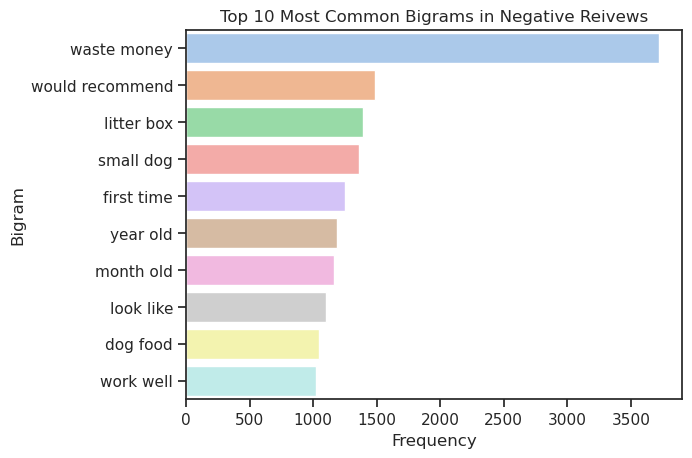

In [59]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(sampled_data[sampled_data['overall'] == -1]['Text1'])

count_values = np.array(bigrams.sum(axis=0)).flatten()
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["Frequency", "Bigram"]

sns.barplot(x=ngram_freq['Frequency'][:10], y=ngram_freq['Bigram'][:10],palette='pastel',hue=ngram_freq['Bigram'][:10], legend=False).set( title='Top 10 Most Common Bigrams in Negative Reivews')

### check how sentiment reviews 

In [79]:
time_data = review.groupby(['year_month', 'overall']).size().reset_index(name='count')
print(time_data)

    year_month  overall  count
0      2013-10     -1.0   5670
1      2013-10      0.0   3420
2      2013-10      1.0  30689
3      2013-11     -1.0   6041
4      2013-11      0.0   3519
..         ...      ...    ...
178    2018-09      0.0    684
179    2018-09      1.0   7960
180    2018-10     -1.0     25
181    2018-10      0.0      7
182    2018-10      1.0    102

[183 rows x 3 columns]


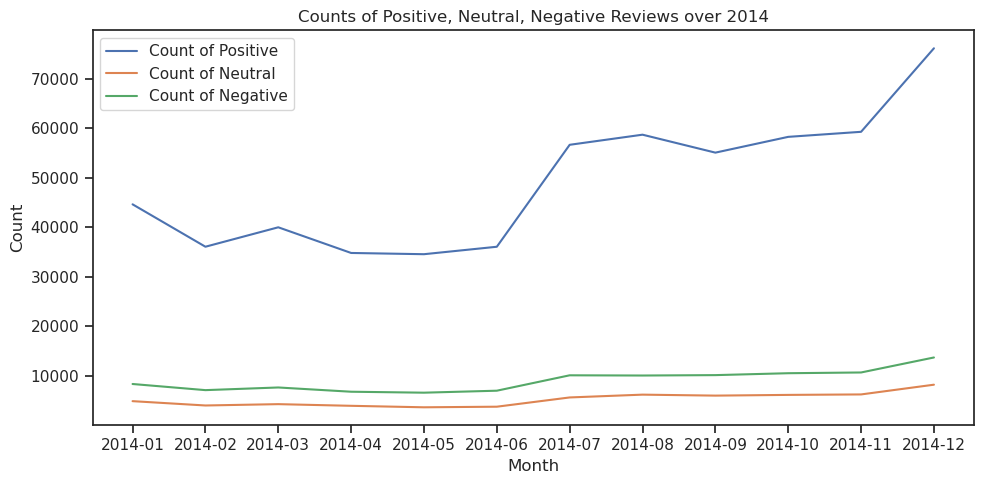

In [98]:
# Filter the data for the year 2014
data_2014 = time_data[(time_data['year_month'] >= '2014-01') & (time_data['year_month'] <= '2014-12')]

# Filter the data for overall values -1, 0, and 1
data_n_1 = data_2014[data_2014['overall'] == -1]
data_0 = data_2014[data_2014['overall'] == 0]
data_p_1 = data_2014[data_2014['overall'] == 1]

plt.figure(figsize=(10, 5))

plt.plot(data_p_1['year_month'], data_p_1['count'], label='Count of Positive')
plt.plot(data_0['year_month'], data_0['count'], label='Count of Neutral')
plt.plot(data_n_1['year_month'], data_n_1['count'], label='Count of Negative')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Positive, Neutral, Negative Reviews over 2014')
plt.legend()

plt.tight_layout()
plt.show()

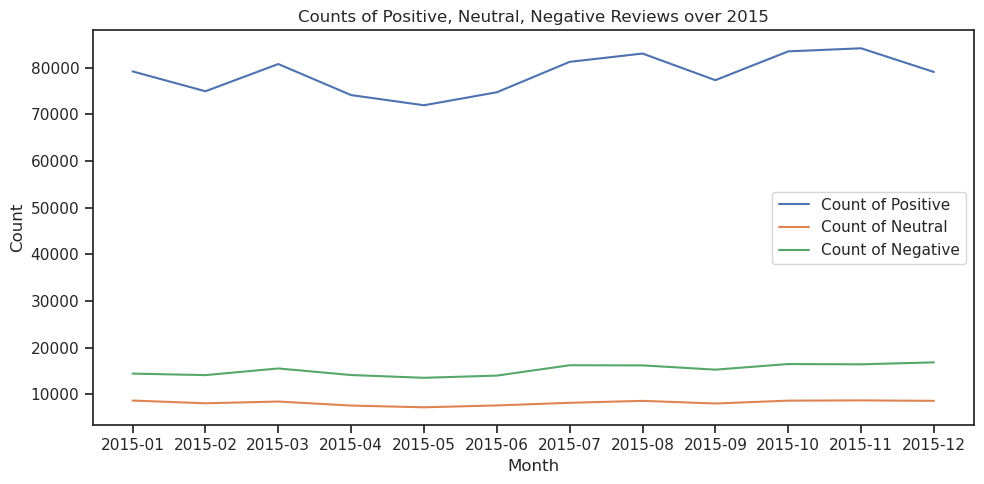

In [97]:
# Filter the data for the year 2015
data_2015 = time_data[(time_data['year_month'] >= '2015-01') & (time_data['year_month'] <= '2015-12')]

# Filter the data for overall values -1, 0, and 1
data_n_1 = data_2015[data_2015['overall'] == -1]
data_0 = data_2015[data_2015['overall'] == 0]
data_p_1 = data_2015[data_2015['overall'] == 1]

plt.figure(figsize=(10, 5))

plt.plot(data_p_1['year_month'], data_p_1['count'], label='Count of Positive')
plt.plot(data_0['year_month'], data_0['count'], label='Count of Neutral')
plt.plot(data_n_1['year_month'], data_n_1['count'], label='Count of Negative')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Positive, Neutral, Negative Reviews over 2015')
plt.legend()

plt.tight_layout()
plt.show()

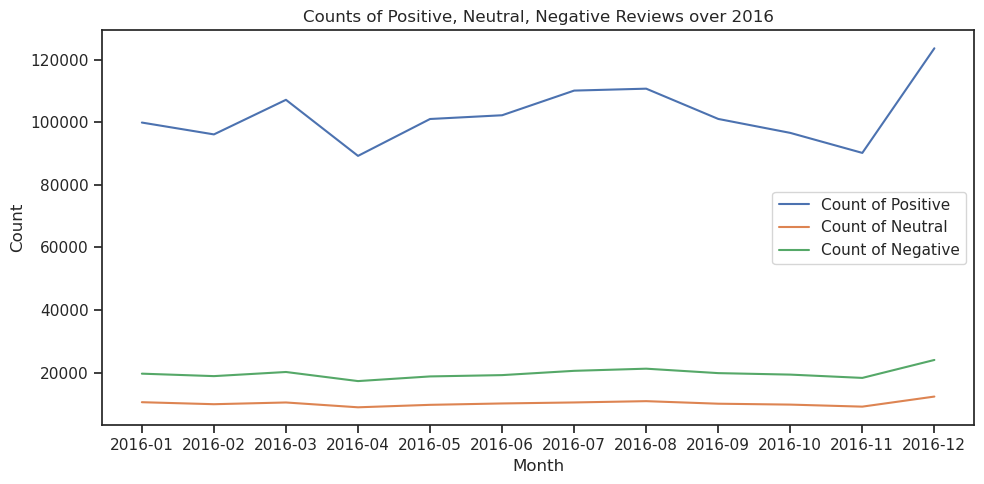

In [96]:
# Filter the data for the year 2016
data_2016 = time_data[(time_data['year_month'] >= '2016-01') & (time_data['year_month'] <= '2016-12')]

# Filter the data for overall values -1, 0, and 1
data_n_1 = data_2016[data_2016['overall'] == -1]
data_0 = data_2016[data_2016['overall'] == 0]
data_p_1 = data_2016[data_2016['overall'] == 1]

plt.figure(figsize=(10, 5))

plt.plot(data_p_1['year_month'], data_p_1['count'], label='Count of Positive')
plt.plot(data_0['year_month'], data_0['count'], label='Count of Neutral')
plt.plot(data_n_1['year_month'], data_n_1['count'], label='Count of Negative')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Positive, Neutral, Negative Reviews over 2016')
plt.legend()

plt.tight_layout()
plt.show()

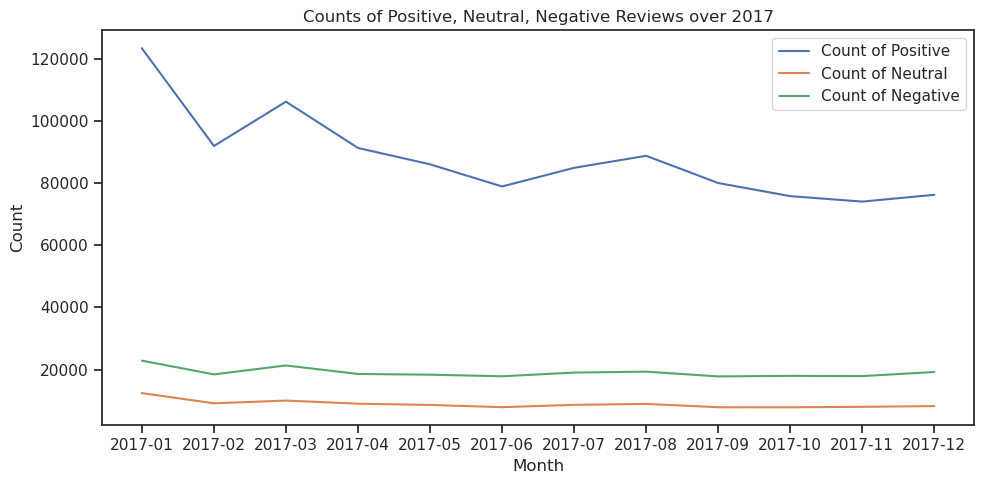

In [99]:
# Filter the data for the year 2017
data_2017 = time_data[(time_data['year_month'] >= '2017-01') & (time_data['year_month'] <= '2017-12')]

# Filter the data for overall values -1, 0, and 1
data_n_1 = data_2017[data_2017['overall'] == -1]
data_0 = data_2017[data_2017['overall'] == 0]
data_p_1 = data_2017[data_2017['overall'] == 1]

plt.figure(figsize=(10, 5))

plt.plot(data_p_1['year_month'], data_p_1['count'], label='Count of Positive')
plt.plot(data_0['year_month'], data_0['count'], label='Count of Neutral')
plt.plot(data_n_1['year_month'], data_n_1['count'], label='Count of Negative')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Positive, Neutral, Negative Reviews over 2017')
plt.legend()

plt.tight_layout()
plt.show()

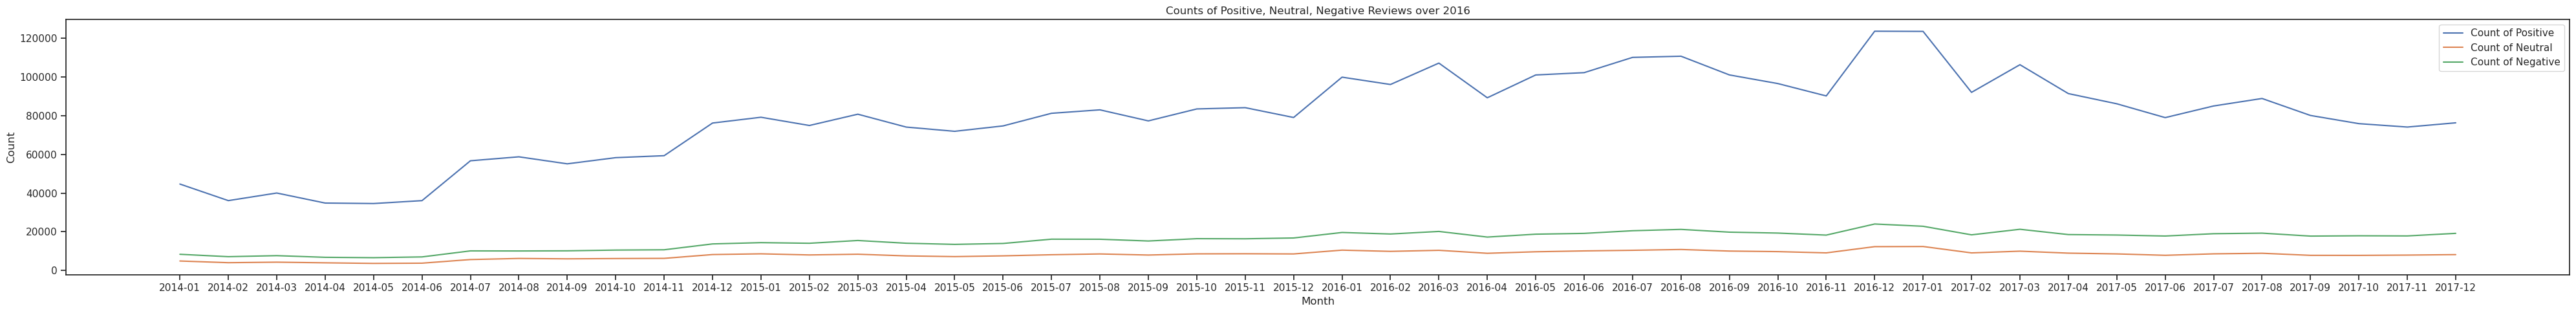

In [105]:
# Filter the data for the year from 2014-01 to 2017-12
data_all = time_data[(time_data['year_month'] >= '2014-01') & (time_data['year_month'] <= '2017-12')]

# Filter the data for overall values -1, 0, and 1
data_n_1 = data_all[data_all['overall'] == -1]
data_0 = data_all[data_all['overall'] == 0]
data_p_1 = data_all[data_all['overall'] == 1]

plt.figure(figsize=(40, 5))

plt.plot(data_p_1['year_month'], data_p_1['count'], label='Count of Positive')
plt.plot(data_0['year_month'], data_0['count'], label='Count of Neutral')
plt.plot(data_n_1['year_month'], data_n_1['count'], label='Count of Negative')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Positive, Neutral, Negative Reviews over 2016')
plt.legend()

plt.tight_layout()
plt.show()

In [154]:
from nltk.tokenize import TreebankWordTokenizer
from collections import Counter
sentence = "The faster Harry got to the store, the faster Harry " \
           "the faster, would get home."
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(sentence.lower())
bag_of_words = Counter(tokens)
print(bag_of_words.most_common(4))

times_harry_appears = bag_of_words['harry']
num_unique_words = len(bag_of_words)
tf = times_harry_appears / num_unique_words; print(tf)



[('the', 4), ('faster', 3), ('harry', 2), (',', 2)]
0.18181818181818182


# Part2:

In [2]:
import tensorflow as tf

2023-12-08 00:37:15.826809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 00:37:15.826865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 00:37:16.000919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 00:37:16.316176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 00:37:18.128209: W tensorflow/compiler/tf2

In [3]:
from tensorflow.keras import activations, optimizers, losses


In [4]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification


In [5]:
import pickle

In [6]:
import pandas as pd
df_raw = pd.read_csv("data.csv")


In [7]:
data = df_raw.copy()

In [8]:
data['overall'] = data['overall'].astype('int')
data.head()

,overall,reviewText,year_month
0,1,I was not happy with product would like to ret...,2016-12
1,1,This cd is scratched and it constantly skips. ...,2016-12
2,4,It works just fine and repeats when I'm not he...,2016-12
3,3,I purchased this cd for my Pocket Parrot. It h...,2016-12
4,3,"Maybe it's just my Amazon parrot, but she's no...",2016-10


In [9]:
data.loc[data["overall"] < 3.0, 'overall'] = 0

In [10]:
data.loc[data["overall"] >= 3.0, 'overall'] = 1

In [11]:
data.isna().sum()

overall          0
reviewText    3928
year_month       0
dtype: int64

In [16]:
data = data.dropna()
print(data.shape)


(5816874, 3)


In [19]:
perc = 0.01  
sampled = data.sample(frac=perc, random_state=42) 

In [20]:
x= sampled['reviewText'].tolist()
y= sampled['overall'].tolist()

In [21]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 20

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)


def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(x, tkzr, max_len=MAX_LEN)

In [22]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, y)

2023-12-08 00:43:52.565399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 00:43:52.582360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 00:43:52.586158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [23]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(x) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [24]:
N_EPOCHS = 2

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2


2023-12-08 00:45:13.828087: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f04697d33c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 00:45:13.828122: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-12-08 00:45:13.851558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-08 00:45:13.904526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1701996314.003834   23749 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23268/23268 [==============================] - 681s 29ms/step - loss: 0.2655 - accuracy: 0.8883
Epoch 2/2
23268/23268 [==============================] - 660s 28ms/step - loss: 0.2212 - accuracy: 0.9098


In [25]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

5817/5817 [==============================] - 57s 10ms/step - loss: 0.1732 - accuracy: 0.9317
{'loss': 0.17317898571491241, 'accuracy': 0.9316657781600952}


In [34]:
def create_predictor(model, model_name, max_len):
  tkzr = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tkzr, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      return preds[0][0]
    
  return predict_proba

clf = create_predictor(model, MODEL_NAME, MAX_LEN)
print(clf('dog love food'))

1/1 [==============================] - 0s 15ms/step
0.0051054196
